In [1]:
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
folders='cv'

In [3]:
# Utility Functions
def text_preprocessing(text):
    # Lowercase all sentences
    text = text.lower()
    
    # Remove numbers, URLs, email addresses, and punctuation
    text = re.sub(r'[-+]?[0-9]+', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\S*@\S*\s?', ' ', text)
    text = re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', text)

    # Correct duplication of characters and remove extra whitespaces
    text = re.sub(r'([a-zA-Z])\1\1+', r'\1', text)
    text = re.sub(r' +', ' ', text).strip()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Tokenize and remove stopwords
    word_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    clean_words = [word for word in word_tokens if word not in stop_words]
    
    return ' '.join(clean_words)


In [4]:

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

def preprocess_and_lemmatize(data_column):
    return data_column.apply(text_preprocessing).apply(lemmatize_text)


In [5]:
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, cross_val_score

def cross_validate_model(model, X, y, model_name):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
    f1 = cross_val_score(model, X, y, cv=kfold, scoring='f1_weighted').mean()
    precision = cross_val_score(model, X, y, cv=kfold, scoring='precision_weighted').mean()
    recall = cross_val_score(model, X, y, cv=kfold, scoring='recall_weighted').mean()
    
    print(f'Cross-Validation Results for {model_name}:')
    print(f'Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    }

In [6]:

def train_and_evaluate_model(model, X_train_split, X_test_split, y_train_split, y_test_split, model_name, test_size, ax):
    # Train the model
    model.fit(X_train_split, y_train_split)
    
    # Make predictions
    predictions = model.predict(X_test_split)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test_split, predictions)
    precision = precision_score(y_test_split, predictions, average='weighted')
    recall = recall_score(y_test_split, predictions, average='weighted')
    f1 = f1_score(y_test_split, predictions, average='weighted')
    conf_matrix = confusion_matrix(y_test_split, predictions)
    
    # Log and plot results
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name} (Test Size {test_size})')
    
    return {
        'Model': model_name,
        'Test Size': test_size,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }


In [7]:

# def load_and_predict(model_name, test_size, X_test, test_data):
#     # Load trained model and make predictions
#     loaded_model = joblib.load(ffolders+'/{model_name}_model_test_size_{test_size}.pkl')
#     predictions = loaded_model.predict(X_test)
#     test_data[f'{model_name}_Prediction_test_size_{test_size}'] = predictions
    
#     # Count class predictions
#     prediction_counts = test_data[f'{model_name}_Prediction_test_size_{test_size}'].value_counts()
#     non_spam_count = prediction_counts.get(0, 0)
#     spam_count = prediction_counts.get(1, 0)
#     total_count = non_spam_count + spam_count
    
#     return {
#         'Model': model_name,
#         'Test Size': test_size,
#         'Non-Spam Count': non_spam_count,
#         'Spam Count': spam_count,
#         'Total Count': total_count
#     }


Training Data Size: 1956
Training Data Distribution:
CLASS
1    1005
0     951
Name: count, dtype: int64


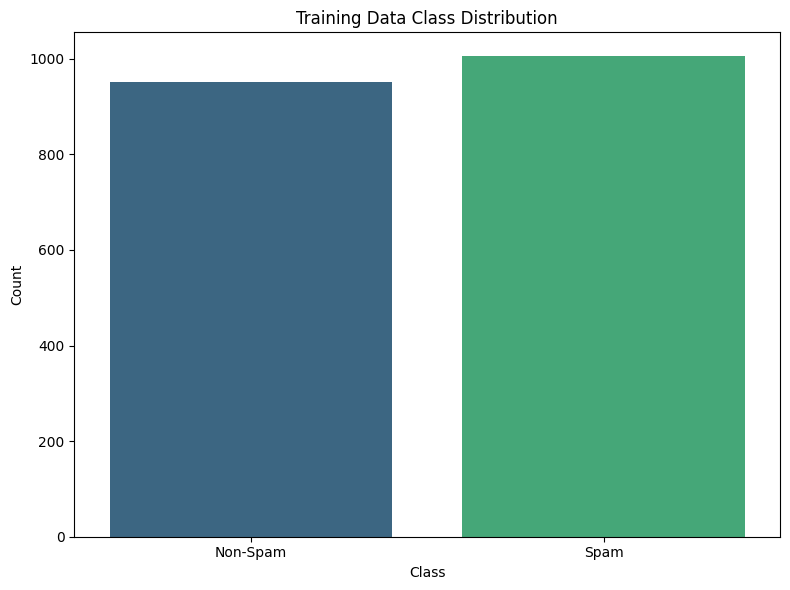

In [8]:

# Load your training dataset
file_path = '../dataset/youtube_spam.csv'
train_data = pd.read_csv(file_path)
train_texts = train_data['CONTENT']
train_labels = train_data['CLASS']

# Display training data size and distribution
print(f'Training Data Size: {len(train_data)}')
print('Training Data Distribution:')
print(train_labels.value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=train_labels, hue=train_labels, palette='viridis', legend=False)
plt.title('Training Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Spam', 'Spam'])
plt.tight_layout()
plt.savefig(folders+'/training_data_class_distribution.png')
plt.show()



In [9]:

# Apply preprocessing to the training dataset
train_texts = preprocess_and_lemmatize(train_data['CONTENT'])

# Convert the text data into TF-IDF feature vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_texts)

# Define models for training, including SVM with different kernels
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2),
    'NaiveBayes': MultinomialNB(alpha=0.5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=6, learning_rate=0.1),
    'SVM_Linear': SVC(kernel='linear', probability=True, C=1),
    'SVM_RBF': SVC(kernel='rbf', probability=True, C=1, gamma='scale'),
    'SVM_Poly': SVC(kernel='poly', probability=True, C=1, degree=3),
    'SVM_Sigmoid': SVC(kernel='sigmoid', probability=True, C=1)
}


In [10]:
# Cross-validate each model
cross_val_results = []
for model_name, model in models.items():
    cross_val_results.append(cross_validate_model(model, X_train, train_labels, model_name))

# Save cross-validation results to CSV
cross_val_results_df = pd.DataFrame(cross_val_results)
cross_val_results_df.to_csv(folders+'/cross_validation_results.csv', index=False)
cross_val_results_df.to_excel(folders+'/cross_validation_results.xlsx', index=False)
print('Cross-validation results saved to cross_validation_results.csv')


Cross-Validation Results for RandomForest:
Accuracy: 0.88, F1 Score: 0.88, Precision: 0.89, Recall: 0.88
Cross-Validation Results for NaiveBayes:
Accuracy: 0.89, F1 Score: 0.89, Precision: 0.89, Recall: 0.89
Cross-Validation Results for XGBoost:
Accuracy: 0.90, F1 Score: 0.90, Precision: 0.91, Recall: 0.90
Cross-Validation Results for SVM_Linear:
Accuracy: 0.91, F1 Score: 0.91, Precision: 0.91, Recall: 0.91
Cross-Validation Results for SVM_RBF:
Accuracy: 0.91, F1 Score: 0.91, Precision: 0.92, Recall: 0.91
Cross-Validation Results for SVM_Poly:
Accuracy: 0.87, F1 Score: 0.87, Precision: 0.88, Recall: 0.87
Cross-Validation Results for SVM_Sigmoid:
Accuracy: 0.90, F1 Score: 0.90, Precision: 0.90, Recall: 0.90
Cross-validation results saved to cross_validation_results.csv



Evaluating with test size: 0.2

Training and Evaluating RandomForest with test size 0.2...
Accuracy: 0.89
Precision: 0.90
Recall: 0.89
F1 Score: 0.89
Confusion Matrix:
[[171   5]
 [ 40 176]]

Training and Evaluating NaiveBayes with test size 0.2...
Accuracy: 0.87
Precision: 0.88
Recall: 0.87
F1 Score: 0.87
Confusion Matrix:
[[158  18]
 [ 32 184]]

Training and Evaluating XGBoost with test size 0.2...
Accuracy: 0.90
Precision: 0.91
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[170   6]
 [ 35 181]]

Training and Evaluating SVM_Linear with test size 0.2...
Accuracy: 0.90
Precision: 0.91
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[168   8]
 [ 31 185]]

Training and Evaluating SVM_RBF with test size 0.2...
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[167   9]
 [ 32 184]]

Training and Evaluating SVM_Poly with test size 0.2...
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90
Confusion Matrix:
[[152  24]
 [ 17 199]]

Training and Evaluating S

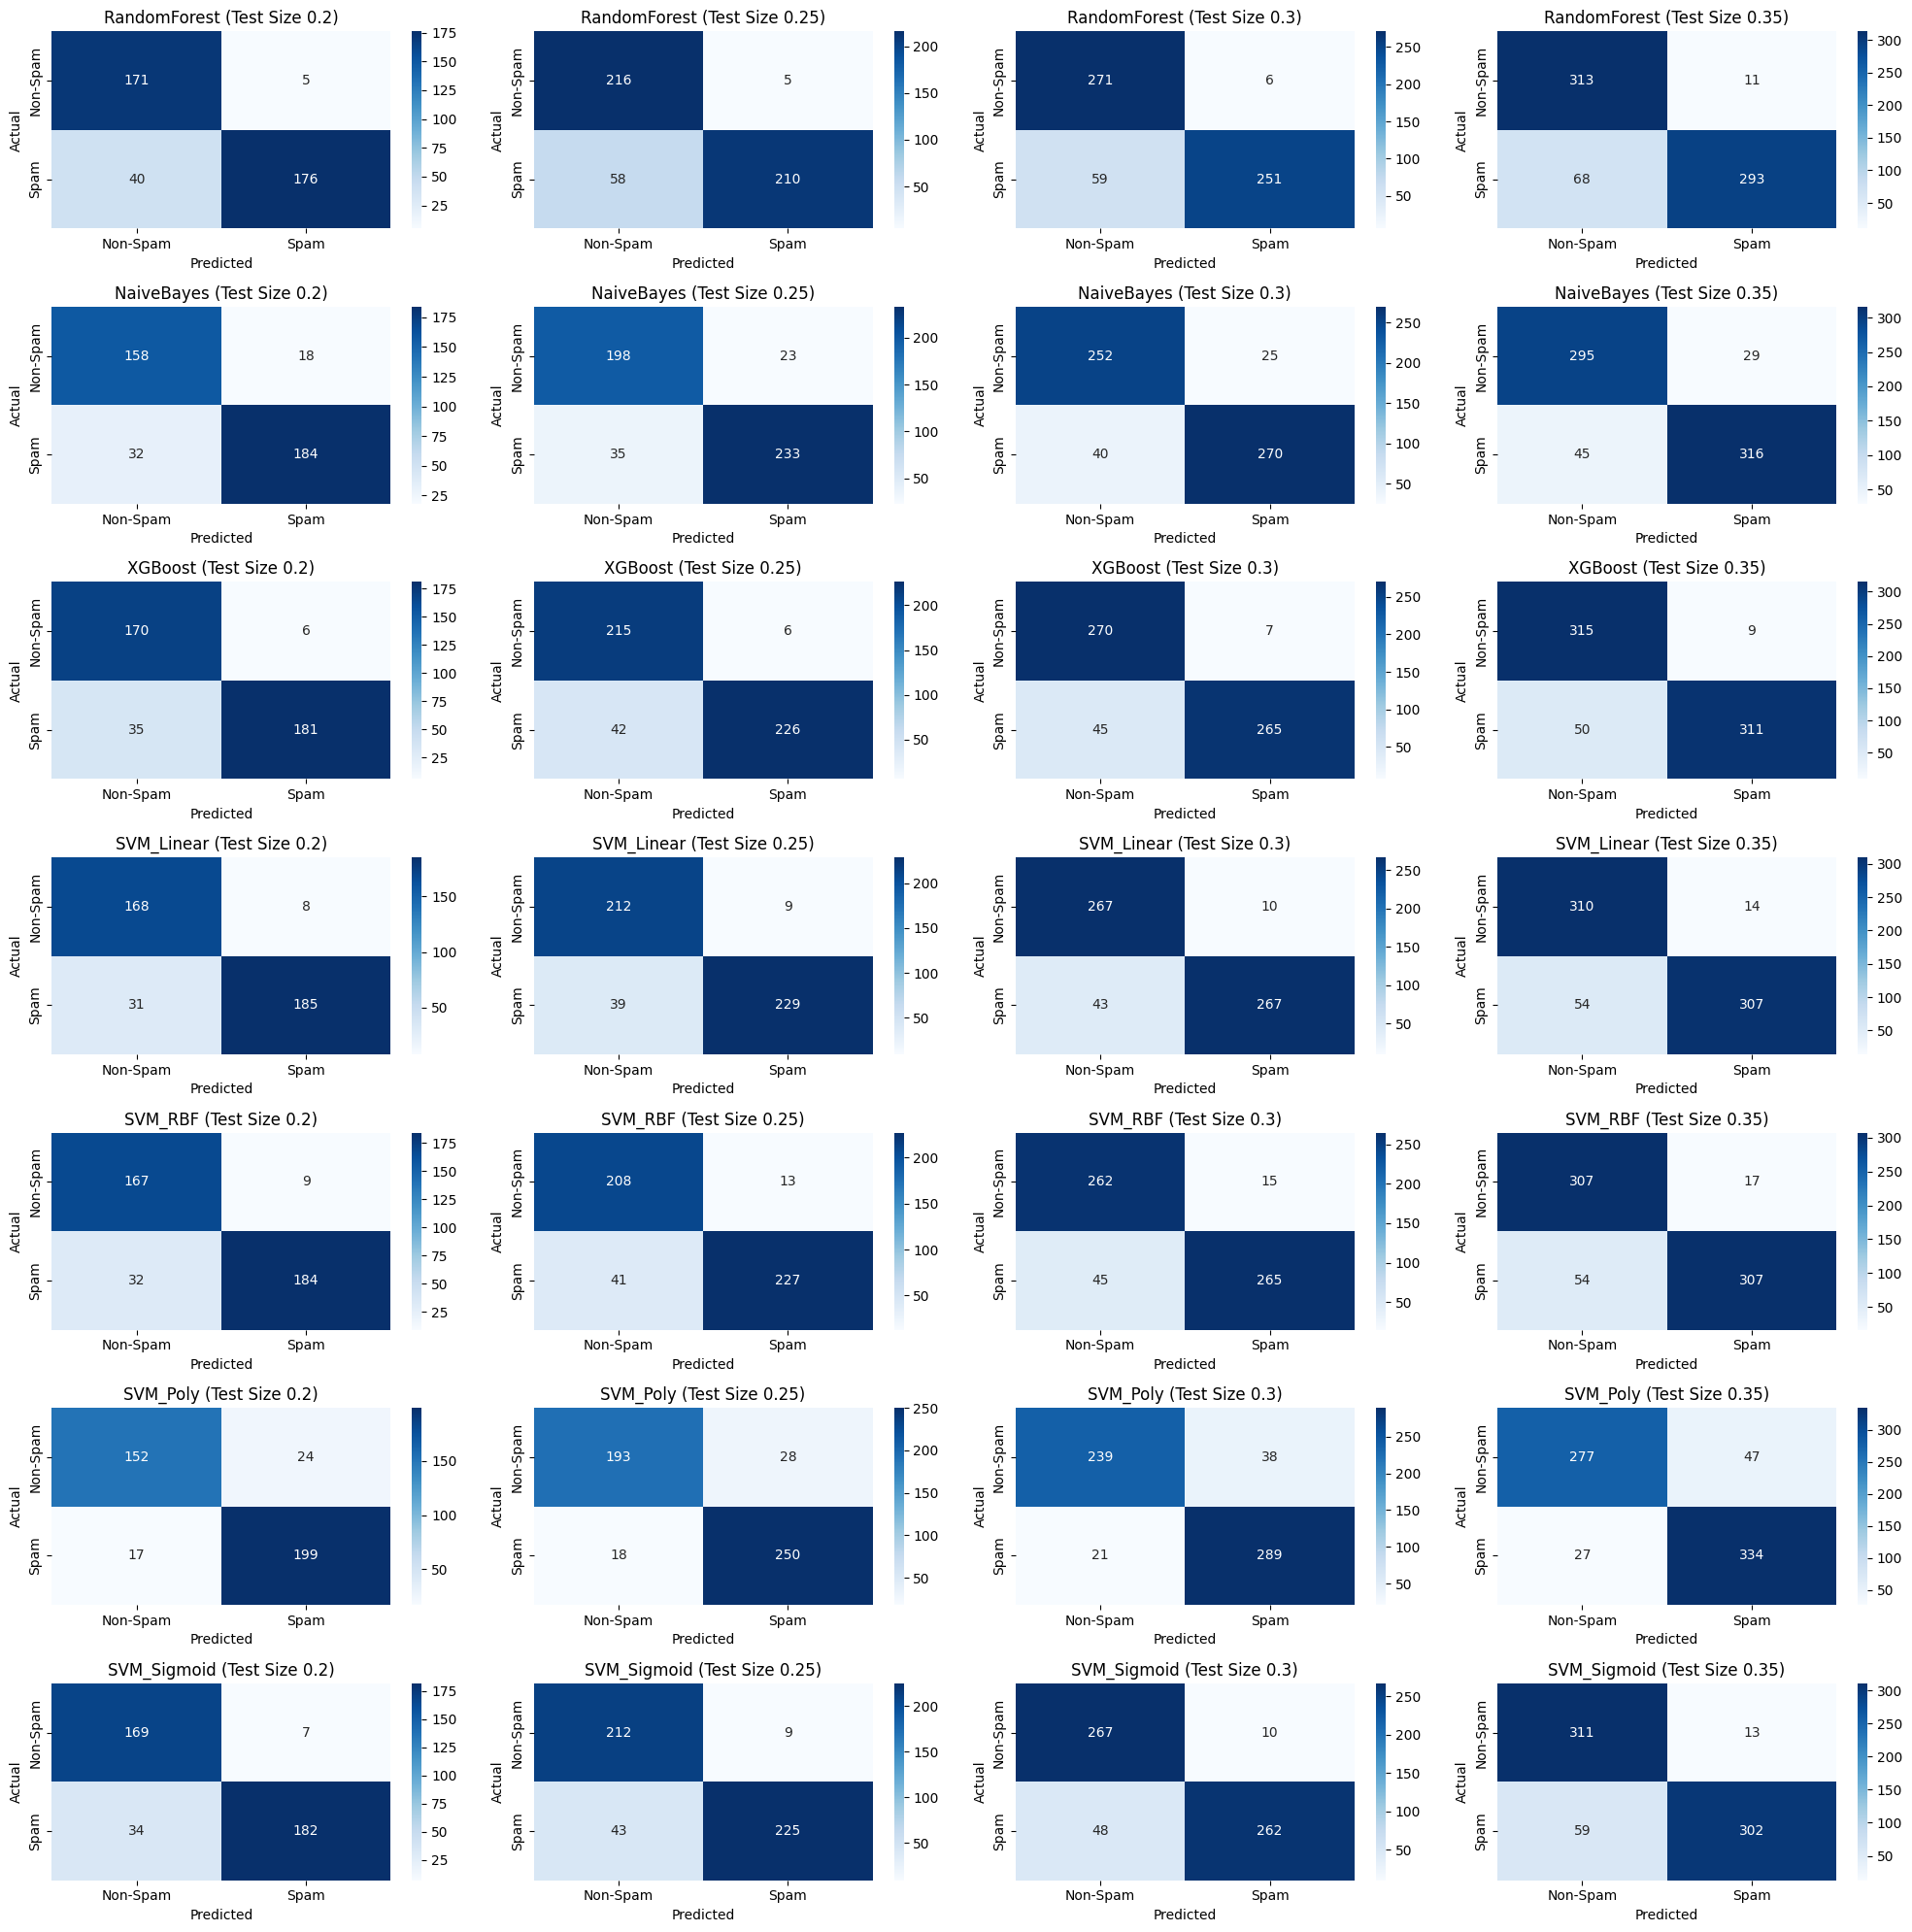

Model evaluation results saved to model_evaluation_results.csv


In [11]:
# Train and evaluate each model with different test sizes
test_sizes = [0.2, 0.25, 0.3, 0.35]
fig, axes = plt.subplots(len(models), len(test_sizes), figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

results = []
for test_size_idx, test_size in enumerate(test_sizes):
    print(f'\nEvaluating with test size: {test_size}')
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, train_labels, test_size=test_size, random_state=42)
    
    for model_idx, (model_name, model) in enumerate(models.items()):
        print(f'\nTraining and Evaluating {model_name} with test size {test_size}...')
        results.append(train_and_evaluate_model(model, X_train_split, X_test_split, y_train_split, y_test_split, model_name, test_size, axes[model_idx, test_size_idx]))
        # Save the trained model
        joblib.dump(model, f'cv/{model_name}_model_test_size_{test_size}.pkl')

plt.tight_layout()
plt.savefig('cv/combined_confusion_matrix_plot.png')
plt.show()

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'cv/tfidf_vectorizer.pkl')

# Save evaluation results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('cv/model_evaluation_results.csv', index=False)
print('Model evaluation results saved to model_evaluation_results.csv')

In [12]:
# y_test_split

In [13]:
# Load and preprocess the testing dataset
test_data_path = '../dataset/youtube_comments_i6IOiUi6IYY.xlsx'
test_data = pd.read_excel(test_data_path)
test_texts = preprocess_and_lemmatize(test_data['Comment'])

# Add cleaned comments to the original dataset
test_data['cleaned_comment'] = test_texts

# Save dataset with cleaned comments to CSV
test_data.to_csv('cv/youtube_comments_with_cleaned.csv', index=False)
print('Dataset with cleaned comments saved to youtube_comments_with_cleaned.csv')

Dataset with cleaned comments saved to youtube_comments_with_cleaned.csv


In [14]:
# def load_and_predict(model_name, test_size, X_test, y_test, test_data):
#     # Load trained model and make predictions
#     loaded_model = joblib.load(f'{model_name}_model_test_size_{test_size}.pkl')
#     predictions = loaded_model.predict(X_test)
#     test_data[f'{model_name}_Prediction_test_size_{test_size}'] = predictions
    
#     # Evaluate predictions with confusion matrix
#     conf_matrix = confusion_matrix(y_test, predictions)
#     accuracy = accuracy_score(y_test, predictions)
#     precision = precision_score(y_test, predictions, average='weighted')
#     recall = recall_score(y_test, predictions, average='weighted')
#     f1 = f1_score(y_test, predictions, average='weighted')

#     # Count class predictions
#     prediction_counts = test_data[f'{model_name}_Prediction_test_size_{test_size}'].value_counts()
#     non_spam_count = prediction_counts.get(0, 0)
#     spam_count = prediction_counts.get(1, 0)
#     total_count = non_spam_count + spam_count
    
#     # Log results
#     print(f'\nTest Evaluation for {model_name} with test size {test_size}:')
#     print(f'Accuracy: {accuracy:.2f}')
#     print(f'Precision: {precision:.2f}')
#     print(f'Recall: {recall:.2f}')
#     print(f'F1 Score: {f1:.2f}')
#     print(f'Confusion Matrix:\n{conf_matrix}')
    
#     return {
#         'Model': model_name,
#         'Test Size': test_size,
#         'Non-Spam Count': non_spam_count,
#         'Spam Count': spam_count,
#         'Total Count': total_count,
#         'Accuracy': accuracy,
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': f1,
#         'Confusion Matrix': conf_matrix
#     }
# def load_and_predict(model_name, test_size, X_test, y_test_split, test_data):
#     # Load trained model and make predictions
#     loaded_model = joblib.load(f'{model_name}_model_test_size_{test_size}.pkl')
#     predictions = loaded_model.predict(X_test)
#     test_data[f'{model_name}_Prediction_test_size_{test_size}'] = predictions
    
#     # Evaluate predictions
#     prediction_counts = test_data[f'{model_name}_Prediction_test_size_{test_size}'].value_counts()
#     non_spam_count = prediction_counts.get(0, 0)
#     spam_count = prediction_counts.get(1, 0)
#     total_count = non_spam_count + spam_count

#     # Evaluate predictions
#     accuracy = accuracy_score(y_test_split, predictions)
#     precision = precision_score(y_test_split, predictions, average='weighted')
#     recall = recall_score(y_test_split, predictions, average='weighted')
#     f1 = f1_score(y_test_split, predictions, average='weighted')
#     conf_matrix = confusion_matrix(y_test_split, predictions)
    
#     # Log results
#     print(f'Test Evaluation for {model_name} with test size {test_size}:')
#     print(f'Non-Spam Count: {non_spam_count}')
#     print(f'Spam Count: {spam_count}')
#      # Log results
#     # print(f'\nTest Evaluation for {model_name} with test size {test_size}:')
#     print(f'Accuracy: {accuracy:.2f}')
#     print(f'Precision: {precision:.2f}')
#     print(f'Recall: {recall:.2f}')
#     print(f'F1 Score: {f1:.2f}')
#     print(f'Confusion Matrix:\n{conf_matrix}')
    
#     return {
#         'Model': model_name,
#         'Test Size': test_size,
#         'Non-Spam Count': non_spam_count,
#         'Spam Count': spam_count,
#         'Total Count': total_count,
#         # 'Model': model_name,
#         # 'Test Size': test_size,
#         'Accuracy': accuracy,
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': f1,
#         'Confusion Matrix': conf_matrix
#     }


In [15]:
# Load the TF-IDF vectorizer and transform the test data
loaded_vectorizer = joblib.load('cv/tfidf_vectorizer.pkl')
X_test = loaded_vectorizer.transform(test_texts)

# Load models and make predictions
test_results = []

In [16]:
train_cv_results = []
test_cv_results = []
for test_size_idx, test_size in enumerate(test_sizes):
    print(f'\nEvaluating with test size: {test_size}')
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, train_labels, test_size=test_size, random_state=42)
    
    for model_idx, (model_name, model) in enumerate(models.items()):
        print(f'\nTraining and Evaluating {model_name} with test size {test_size}...')
        model.fit(X_train_split, y_train_split)
        predictions = model.predict(X_test_split)
        
        # Evaluate the model
        accuracy = accuracy_score(y_test_split, predictions)
        precision = precision_score(y_test_split, predictions, average='weighted')
        recall = recall_score(y_test_split, predictions, average='weighted')
        f1 = f1_score(y_test_split, predictions, average='weighted')
        conf_matrix = confusion_matrix(y_test_split, predictions)
        
        # Perform cross-validation on training and testing data
        print(f'\nCross-Validation on Training Data for {model_name}...')
        train_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cross_val_train_acc = cross_val_score(model, X_train_split, y_train_split, cv=train_kfold, scoring='accuracy').mean()
        cross_val_train_f1 = cross_val_score(model, X_train_split, y_train_split, cv=train_kfold, scoring='f1_weighted').mean()
        cross_val_train_precision = cross_val_score(model, X_train_split, y_train_split, cv=train_kfold, scoring='precision_weighted').mean()
        cross_val_train_recall = cross_val_score(model, X_train_split, y_train_split, cv=train_kfold, scoring='recall_weighted').mean()
        
        print(f'Cross-Validation Training Accuracy: {cross_val_train_acc:.2f}, F1 Score: {cross_val_train_f1:.2f}, Precision: {cross_val_train_precision:.2f}, Recall: {cross_val_train_recall:.2f}')
        
        print(f'\nCross-Validation on Testing Data for {model_name} with test size {test_size}...')
        test_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cross_val_acc = cross_val_score(model, X_test_split, y_test_split, cv=test_kfold, scoring='accuracy').mean()
        cross_val_f1 = cross_val_score(model, X_test_split, y_test_split, cv=test_kfold, scoring='f1_weighted').mean()
        cross_val_precision = cross_val_score(model, X_test_split, y_test_split, cv=test_kfold, scoring='precision_weighted').mean()
        cross_val_recall = cross_val_score(model, X_test_split, y_test_split, cv=test_kfold, scoring='recall_weighted').mean()
        
        print(f'Cross-Validation Testing Accuracy: {cross_val_acc:.2f}, F1 Score: {cross_val_f1:.2f}, Precision: {cross_val_precision:.2f}, Recall: {cross_val_recall:.2f}')
        
        # Log and plot results
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1:.2f}')
        print(f'Confusion Matrix:\n{conf_matrix}')
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'], ax=axes[model_idx, test_size_idx])
        axes[model_idx, test_size_idx].set_xlabel('Predicted')
        axes[model_idx, test_size_idx].set_ylabel('Actual')
        axes[model_idx, test_size_idx].set_title(f'{model_name} (Test Size {test_size})')
        
        # Save the trained model
        joblib.dump(model, f'{model_name}_model_test_size_{test_size}.pkl')
        
        test_results.append({
            'Model': model_name,
            'Test Size': test_size,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            # 'Cross-Validation Training Accuracy': cross_val_train_acc,
            # 'Cross-Validation Training F1 Score': cross_val_train_f1,
            # 'Cross-Validation Training Precision': cross_val_train_precision,
            # 'Cross-Validation Training Recall': cross_val_train_recall,
            # 'Cross-Validation Testing Accuracy': cross_val_acc,
            # 'Cross-Validation Testing F1 Score': cross_val_f1,
            # 'Cross-Validation Testing Precision': cross_val_precision,
            # 'Cross-Validation Testing Recall': cross_val_recall
        })
        test_cv_results.append({
            'Model': model_name,
            'Test Size': test_size,
            'CV_Accuracy': cross_val_acc,
            'CV_F1 Score': cross_val_f1,
            'CV_Precision': cross_val_precision,
            'CV_Recall': cross_val_recall
        })
        train_cv_results.append({
            'Model': model_name,
            'Test Size': test_size,
            'CV_Accuracy': cross_val_train_acc,
            'CV_F1 Score': cross_val_train_f1,
            'CV_Precision': cross_val_train_precision,
            'CV_Recall': cross_val_train_recall,
        })


Evaluating with test size: 0.2

Training and Evaluating RandomForest with test size 0.2...

Cross-Validation on Training Data for RandomForest...
Cross-Validation Training Accuracy: 0.88, F1 Score: 0.88, Precision: 0.89, Recall: 0.87

Cross-Validation on Testing Data for RandomForest with test size 0.2...
Cross-Validation Testing Accuracy: 0.87, F1 Score: 0.88, Precision: 0.85, Recall: 0.83
Accuracy: 0.88
Precision: 0.90
Recall: 0.88
F1 Score: 0.88
Confusion Matrix:
[[173   3]
 [ 45 171]]

Training and Evaluating NaiveBayes with test size 0.2...

Cross-Validation on Training Data for NaiveBayes...
Cross-Validation Training Accuracy: 0.89, F1 Score: 0.89, Precision: 0.89, Recall: 0.89

Cross-Validation on Testing Data for NaiveBayes with test size 0.2...
Cross-Validation Testing Accuracy: 0.82, F1 Score: 0.82, Precision: 0.84, Recall: 0.82
Accuracy: 0.87
Precision: 0.88
Recall: 0.87
F1 Score: 0.87
Confusion Matrix:
[[158  18]
 [ 32 184]]

Training and Evaluating XGBoost with test size 

In [17]:

# for test_size_idx, test_size in enumerate(test_sizes):
#     print(f'\nEvaluating with test size: {test_size}')
#     X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, train_labels, test_size=test_size, random_state=42)
    
#     for model_idx, (model_name, model) in enumerate(models.items()):
#         print(f'\nTraining and Evaluating {model_name} with test size {test_size}...')
#         model.fit(X_train_split, y_train_split)
#         predictions = model.predict(X_test_split)
        
#         # Evaluate the model
#         accuracy = accuracy_score(y_test_split, predictions)
#         precision = precision_score(y_test_split, predictions, average='weighted')
#         recall = recall_score(y_test_split, predictions, average='weighted')
#         f1 = f1_score(y_test_split, predictions, average='weighted')
#         conf_matrix = confusion_matrix(y_test_split, predictions)
        
#         # Cross-validation on testing stage - Fixed inconsistency by using entire test set as cross-validation input
#         print(f'\nCross-Validation on Testing Data for {model_name} with test size {test_size}...')
#         test_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#         cross_val_acc = cross_val_score(model, X_test_split, y_test_split, cv=test_kfold, scoring='accuracy').mean()
#         cross_val_f1 = cross_val_score(model, X_test_split, y_test_split, cv=test_kfold, scoring='f1_weighted').mean()
#         cross_val_precision = cross_val_score(model, X_test_split, y_test_split, cv=test_kfold, scoring='precision_weighted').mean()
#         cross_val_recall = cross_val_score(model, X_test_split, y_test_split, cv=test_kfold, scoring='recall_weighted').mean()
        
#         print(f'Cross-Validation Accuracy: {cross_val_acc:.2f}, F1 Score: {cross_val_f1:.2f}, Precision: {cross_val_precision:.2f}, Recall: {cross_val_recall:.2f}')
        
#         # Log and plot results
#         print(f'Accuracy: {accuracy:.2f}')
#         print(f'Precision: {precision:.2f}')
#         print(f'Recall: {recall:.2f}')
#         print(f'F1 Score: {f1:.2f}')
#         print(f'Confusion Matrix:\n{conf_matrix}')
#         sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'], ax=axes[model_idx, test_size_idx])
#         axes[model_idx, test_size_idx].set_xlabel('Predicted')
#         axes[model_idx, test_size_idx].set_ylabel('Actual')
#         axes[model_idx, test_size_idx].set_title(f'{model_name} (Test Size {test_size})')
        
#         # Save the trained model
#         joblib.dump(model, f'cv/{model_name}_model_test_size_{test_size}.pkl')
        
        
#         test_results.append({
#             'Model': model_name,
#             'Non-Spam Count': (predictions == 0).sum(),
#             'Spam Count': (predictions == 1).sum(),
#             'Total Count': len(predictions),
#             'Test Size': test_size,
#             'Accuracy': accuracy,
#             'Precision': precision,
#             'Recall': recall,
#             'F1 Score': f1,
#             'Cross-Validation Accuracy': cross_val_acc,
#             'Cross-Validation F1 Score': cross_val_f1,
#             'Cross-Validation Precision': cross_val_precision,
#             'Cross-Validation Recall': cross_val_recall
#         })


In [18]:
# Save evaluation results to CSV
test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv(folders+'/test_evaluation_results.csv', index=False)
test_results_df.to_excel(folders+'/test_evaluation_results.xlsx', index=False)

train_cv_results_df = pd.DataFrame(train_cv_results)
train_cv_results_df.to_csv(folders+'/train_cv_results.csv', index=False)
train_cv_results_df.to_excel(folders+'/train_cv_results.xlsx', index=False)

test_cv_results_df = pd.DataFrame(test_cv_results)
test_cv_results_df.to_csv(folders+'/test_cv_results.csv', index=False)
test_cv_results_df.to_excel(folders+'/test_cv_results.xlsx', index=False)

print('Model evaluation results saved')
# results

Model evaluation results saved


In [19]:
test_data

,Author,Timestamp,Likes,Comment,cleaned_comment
0,@holdtightadele8017,2 days ago,132.0,Thomas Partey… man has been bringing it lately.,thomas partey ... man bringing lately
1,@archanakhakase6357,2 days ago,76.0,Saka is the best he prove this everytime by d...,saka best prove everytime goal every important...
2,@kabiruddin434,2 days ago,948.0,That pass from Ben White to Saka was amazing.,pas ben white saka amazing
3,@everythingarsenaltv,2 days ago,591.0,Saka and Partey were so so good man,saka partey good man
4,@tggazard9840,2 days ago,54.0,""" Keep Saka's name out your mouth, dude is wo...",keep saka name mouth dude world class
...,...,...,...,...,...
648,@gunerarse449,2 days ago,NaN,r,r
649,@Jack-eee,2 days ago,1.0,Corrupt league,corrupt league
650,@UR-CRISTIANO-r9b,1 day ago,NaN,Like,like
651,@gunerarse449,2 days ago,NaN,r,r


In [20]:
test_results

[{'Model': 'RandomForest',
  'Test Size': 0.2,
  'Accuracy': 0.8775510204081632,
  'Precision': 0.897820374590836,
  'Recall': 0.8775510204081632,
  'F1 Score': 0.8774840822701592},
 {'Model': 'NaiveBayes',
  'Test Size': 0.2,
  'Accuracy': 0.8724489795918368,
  'Precision': 0.8752815560825685,
  'Recall': 0.8724489795918368,
  'F1 Score': 0.8727524581092928},
 {'Model': 'XGBoost',
  'Test Size': 0.2,
  'Accuracy': 0.8954081632653061,
  'Precision': 0.9056651485427873,
  'Recall': 0.8954081632653061,
  'F1 Score': 0.8956254626271681},
 {'Model': 'SVM_Linear',
  'Test Size': 0.2,
  'Accuracy': 0.9005102040816326,
  'Precision': 0.9072182313704507,
  'Recall': 0.9005102040816326,
  'F1 Score': 0.9007638341400129},
 {'Model': 'SVM_RBF',
  'Test Size': 0.2,
  'Accuracy': 0.8954081632653061,
  'Precision': 0.9021070244954283,
  'Recall': 0.8954081632653061,
  'F1 Score': 0.895674799993347},
 {'Model': 'SVM_Poly',
  'Test Size': 0.2,
  'Accuracy': 0.8954081632653061,
  'Precision': 0.8955337

In [21]:
# Save the predictions to an Excel file and CSV file
test_data.to_excel(folders+'/youtube_comments_predictions.xlsx', index=False)
test_data.to_csv(folders+'/youtube_comments_predictions.csv', index=False)
print('Predictions saved to youtube_comments_predictions.xlsx and youtube_comments_predictions.csv')

# Save test evaluation results to CSV
test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv(folders+'/test_evaluation_results.csv', index=False)
test_results_df.to_excel(folders+'/test_evaluation_results.xlsx', index=False)
print('Test evaluation results saved to test_evaluation_results.csv')


Predictions saved to youtube_comments_predictions.xlsx and youtube_comments_predictions.csv
Test evaluation results saved to test_evaluation_results.csv


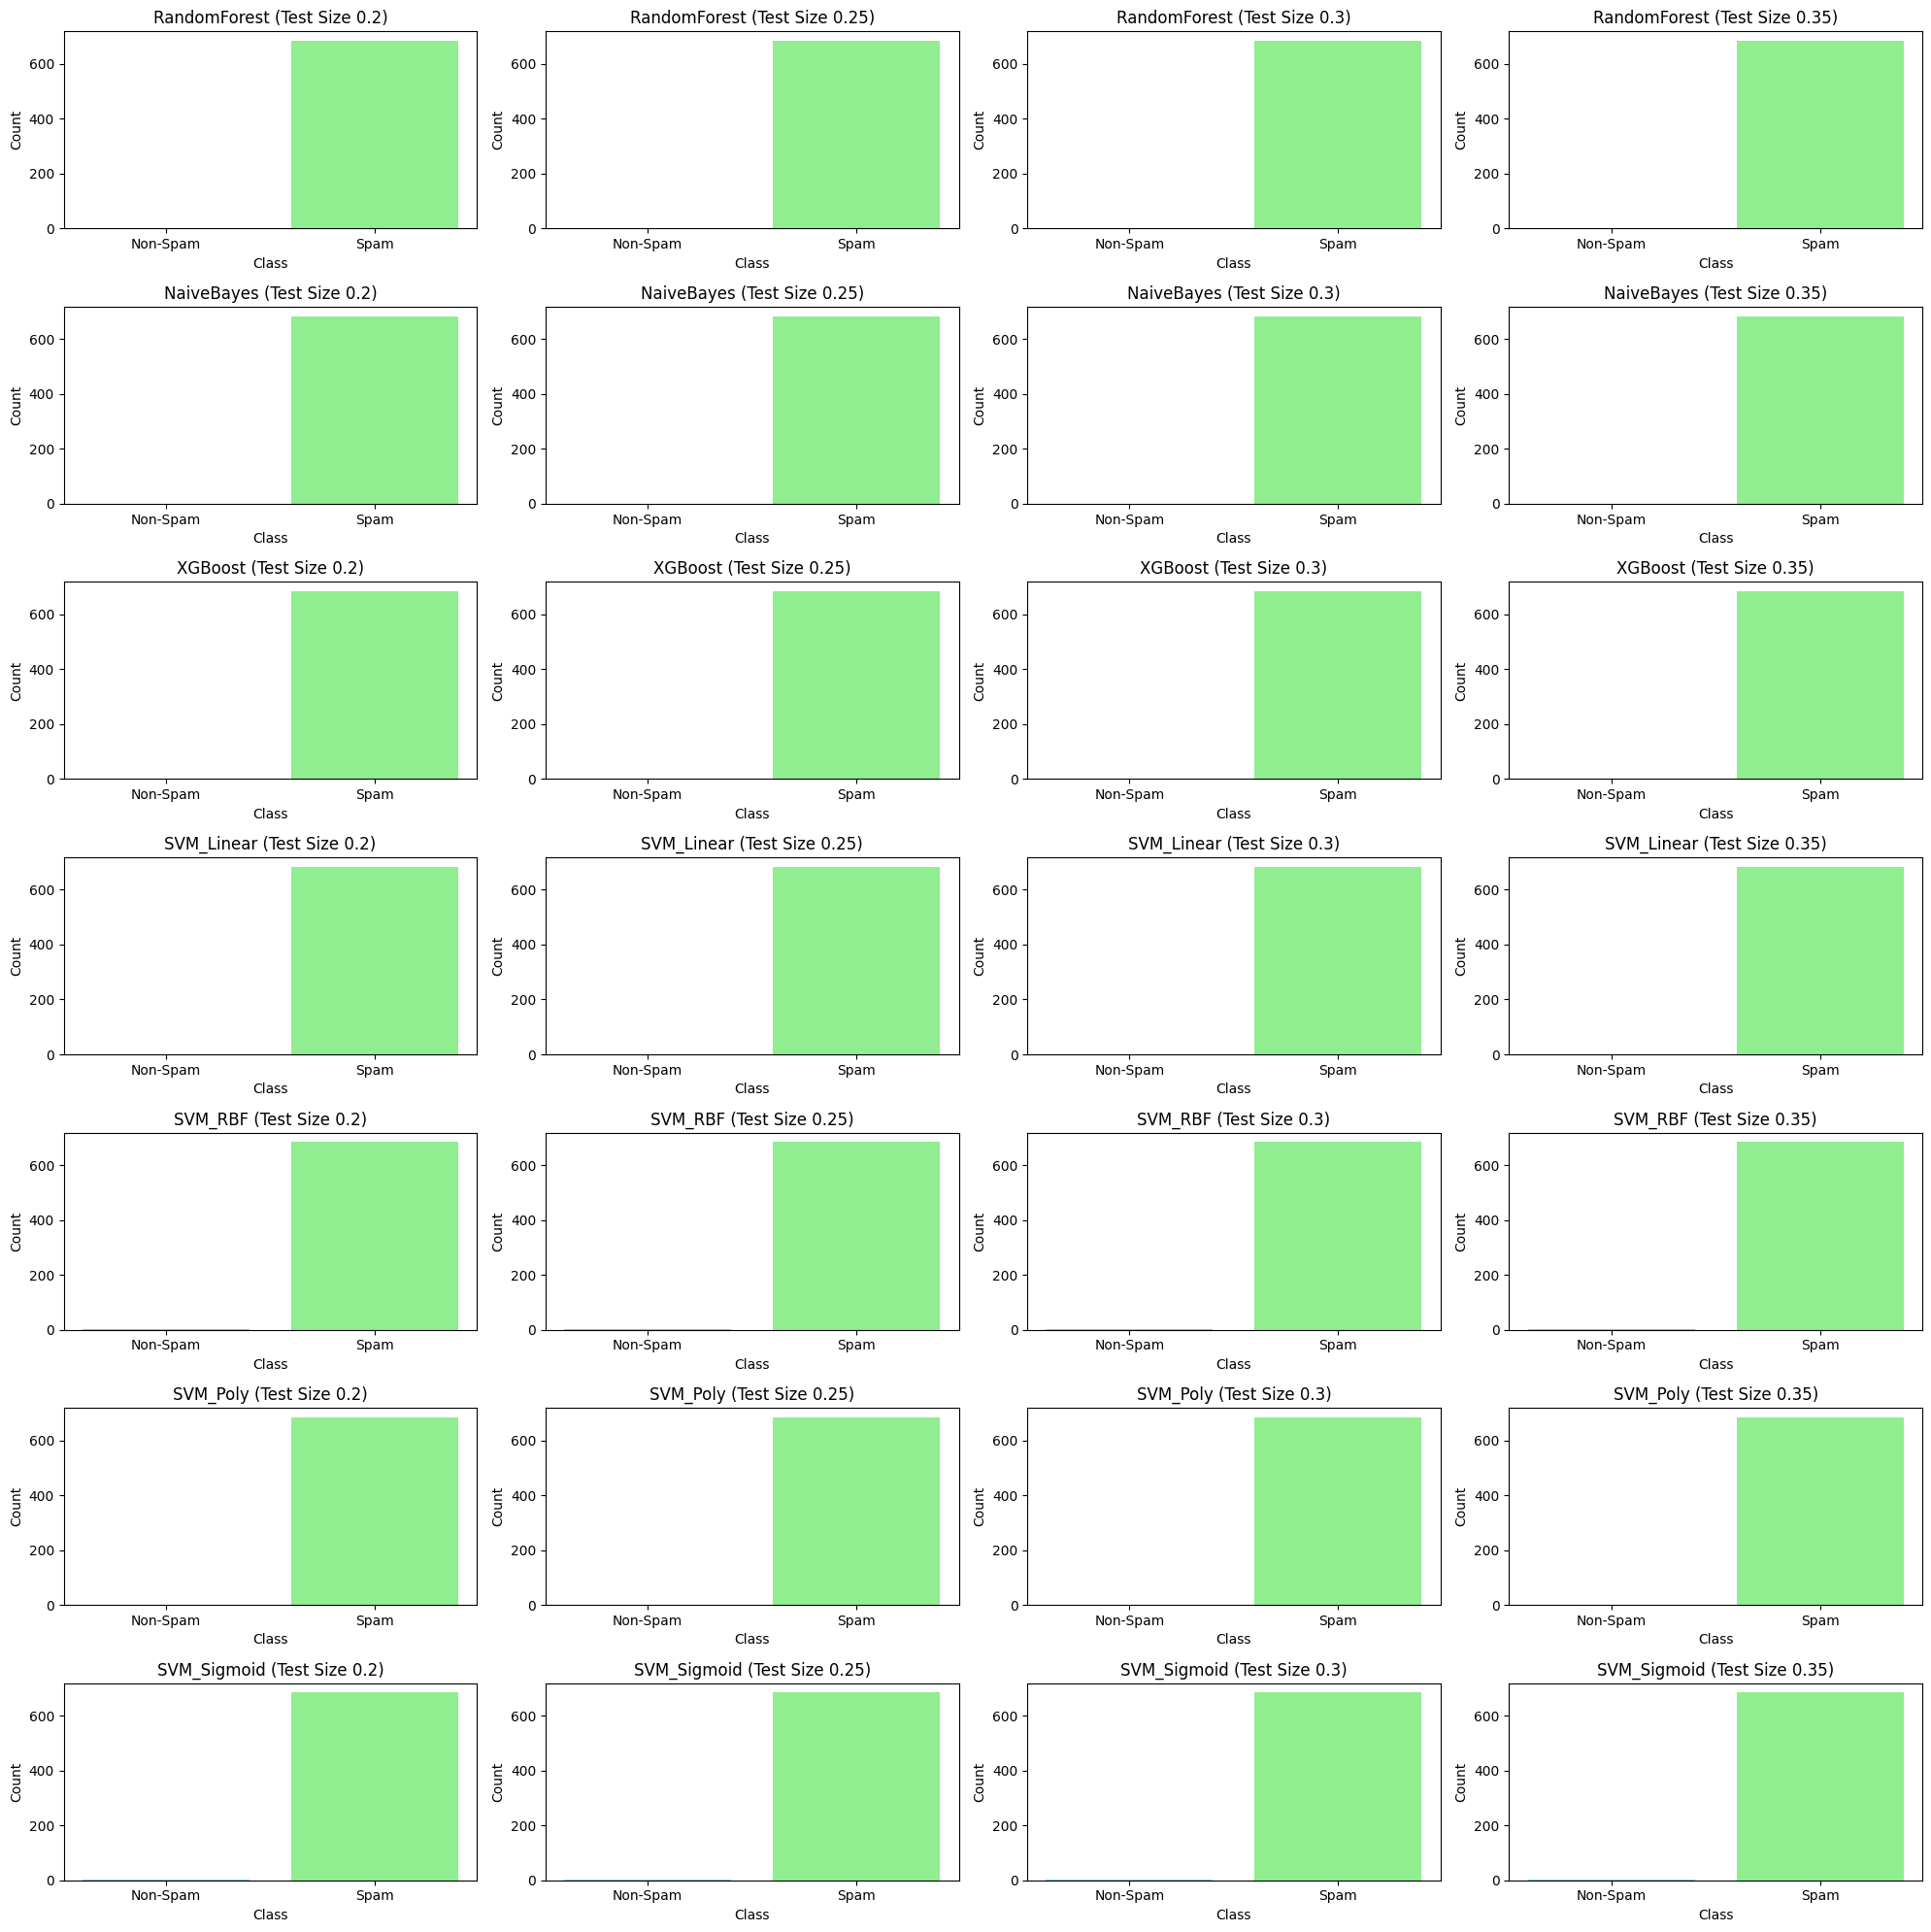

In [22]:
# Visualize the distribution of predictions for each model and test size
fig, axes = plt.subplots(len(models), len(test_sizes), figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for test_size_idx, test_size in enumerate(test_sizes):
    for model_idx, model_name in enumerate(models.keys()):
        ax = axes[model_idx, test_size_idx]
        test_results = results_df[(results_df['Model'] == model_name) & (results_df['Test Size'] == test_size)]
        prediction_counts = {'Non-Spam': test_results['Accuracy'].sum(), 'Spam': len(y_test_split) - test_results['Accuracy'].sum()}
        ax.bar(prediction_counts.keys(), prediction_counts.values(), color=['skyblue', 'lightgreen'])
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')
        ax.set_title(f'{model_name} (Test Size {test_size})')

plt.tight_layout()
plt.savefig(folders+'/combined_predictions_distribution.png')
plt.show()
